# Script for OPENSENSE Training School 2023 - L. de Vos & J. Seidel
# PWSQC method - Impact of parameter choices
### The code below is derived from the R-scripts on https://github.com/LottedeVos/PWSQC/ , also available in the OPENSENSE Sandbox ( https://github.com/NiekvanAndel/QC_radar/blob/main/script_1_0.py is evaluated as inspiration for the translation to Python).

# A. Load AMS dataset and metadata
The 5-min PWS dataset of the Amsterdam metropolatan area is used for these exercises. The original data set is published on https://doi.org/10.4121/uuid:6e6a9788-49fc-4635-a43d-a2fa164d37ec (AMS_dataset and AMS_metadata).


### A 1.0 Import packages and adjust settings

In [1]:
# Import the required python modules
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10}) # Set plot font size to 16pt

import numpy as np
import time
import tqdm
import zipfile
import os
import pandas as pd
import datetime
import FZ_filter as FZ
from pycomlink.spatial.helper import haversine

### A 1.1 Load the csv data files and create DataFrames and Array for further analysis

In [2]:
# Relative path to the data directory
main_dir = r".././data/pws/"
# PWS 5 Minute data files
path_pws_data_zip = os.path.join(main_dir, r"AMS_dataset.zip")   
path_pws_metadata = os.path.join(main_dir, r"AMS_metadata.csv")

In [3]:
with zipfile.ZipFile(path_pws_data_zip, 'r') as zip_ref:
    zip_ref.extractall(main_dir)

In [4]:
path_pws_data = os.path.join(main_dir, r"AMS_dataset.csv")   


In [5]:
# Read the AMS data into DataFrames
AMS_dataset = pd.read_csv(path_pws_data,header=0, sep=',', index_col='Time')
AMS_metadata = pd.read_csv(path_pws_metadata,header=0, sep=',', index_col='ID' )

In [6]:
# Define start and end time and time steps
starttime = AMS_dataset.index[0]
endtime = AMS_dataset.index[-1]
Time = [datetime.datetime.strptime(t, "%Y-%m-%d %H:%M:%S").replace(tzinfo=datetime.timezone.utc) for t in AMS_dataset.index]

In [7]:
# Arraf for the PWS precipitaiton values
Ndataset = AMS_dataset.values
# Create the Meta data set with coordinated and PWS IDs
AMS_metadata = pd.read_csv(path_pws_metadata,header=0, sep=',')
AMS_metadata = AMS_metadata.rename(columns={'ID': 'id'})
AMS_metadata.columns.values[0] = "id"
Meta = AMS_metadata

# B. How to select neighbours?

The PWSQC method relies on comparing observations with those from nearby PWSs. What is considered 'nearby' is defined with parameter `r_range`, the distance in meter from the primary PWS. For the FZ and HI filter, the median amount of all neighbours is calculated as reference. This means also that the range should be chosen as the distance over which rainfall dynamics match the primary location at the time scales you're evaluating. In order to make this reference robust enough, another parameter `nstat` is introduced. Only when at least `nstat` amount of PWSs in the range generate an observation at that timestep, the comparison can be made. It can occur that for a certain network the number of neighbours of a PWS exceeds `nstat`, but at a certain timestep some of those neighbours lack observations. Therefore, the `nstat` limit is checked each timestep. If the number of neighbours of a station is below `nstat`, you know that the FZ and HI comparison can never be made, as the minimum criteria for `nstat` is never met. 

In a dense network, `r_range` can be small and `nstat` can be large. In a sparse network the reverse is true. For the choice of `r_range` it is important to consider over which spatial distance you compare PWSs to measure the same rainfall at the time resolution of your data (in the example of the Amsterdam dataset we have 5min resolution, but larger ranges are fitting for hourly values). From there, a choice for `nstat` should be such that the calculated median is robust, but not too strict that your FZ and HI qualitychecks become not applicable in most time intervals. 

The exercise below visualizes the division of the number of neighbours and how often the number will always be below the minimum threshold for self chosen values of range and stat in the Amsterdam dataset. 
 


## EXERCISE 1

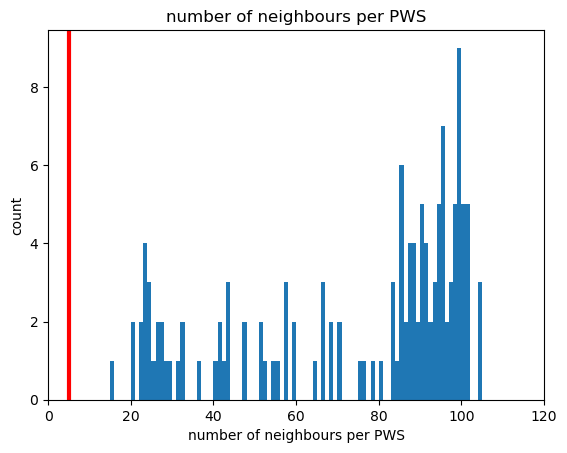

In [8]:
r_range = 10000
nstat = 5

neighbourlist = [[] for _ in np.arange(Meta.shape[0])]
for i in np.arange(Meta.shape[0]):
    dist = [
        haversine(
            Meta.loc[j, "lon"],Meta.loc[j, "lat"],
            Meta.loc[i, "lon"], Meta.loc[i, "lat"],
        )*1000
        for j in np.arange(Meta.shape[0])
    ]
    neighbourlist[i] = [
        Meta.loc[j, "id"]
        for j in np.arange(Meta.shape[0])
        if dist[j] > 0 and dist[j] <= r_range
    ]

# import matplotlib.pyplot as plt

plt.hist([len(neighbours) for neighbours in neighbourlist], bins=np.arange(0, 120))
plt.title("number of neighbours per PWS")
plt.xlim(0, 120)
plt.xlabel("number of neighbours per PWS")
plt.ylabel("count")
plt.axvline(x=nstat, color="red", linewidth=3);

## 1. Questions

Change the parameters `r_range` and `nstat` and evaluate how the histogram changes. How many neighbours to PWSs typically have with those parameters? How many stations no longer have enough neigbours to perform QC chekcks?

Consider how the parameters relate to:
* the density of the network
* the spatial scales of rainfall in the climate where the network is situated for the time resolution of the data
* how accurate you expect raw measurements to be

Run the code of Exercise 1 again with parameters `r_range` = 10000 and `nstat` = 5 and continue. 

# C. PARAMETERS FOR High-Influx (HI) FILTER

In the PWSQC method the HI-filter compares individual PWS observations against the median value of its neighbours at that timestamp. There is no fixed allowed difference between the two, as during a heavy rainfall events the difference in rainfall measurements of neigbouring PWS can be far larger than during light rainfall events. To take this into account, two parameters define above which upper limit a PWS observation is considered an outlier. 
Parameter `HIthresA` indicates the value of the neighbours below which we consider a fixed upper limit of amount `HIthresB`. When the median rainfall measured by the neighbours exceeds `HIthresA`, the upper limit becomes linearly dependent of the neighbours, with a factor (`HIthresB`/`HIthresA`). 

The exercise below visualizes the relation between upper limit and median rainfall as measured by neighbours for various choices of parameters. On the  left of the dashed grey line, the upper limit is indicated by the blue horizontal line. On the right of the dashed line, the upper limit is the red line. 
 

## EXERCISE 2

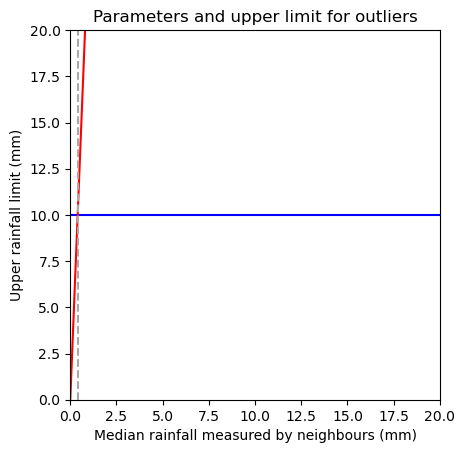

In [9]:
# Parameters for the HI-filter
HIthresA = 0.4
HIthresB = 10


plt.plot([], [])
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.title("Parameters and upper limit for outliers")
plt.xlabel("Median rainfall measured by neighbours (mm)")
plt.ylabel("Upper rainfall limit (mm)")
plt.gca().set_aspect('equal', adjustable='box')
plt.axhline(HIthresB, color="blue")
# Plot issue: line between points -> origin and (HitreshA/HitreshB)
plt.axline([0,0],slope=HIthresB/HIthresA, color="red")
plt.axvline(HIthresA, linestyle="--", color="darkgrey")

plt.show()

# 2. Questions

Try the combination `HIthresA` = 5 and `HIthresB` = 5 and visualize the result.
* if PWS neighbours measure a median of 4 mm rainfall, and the PWS itself 6 mm, will it receive a HI-flag with these parameters?
* and for median of 10 mm and PWS of 10 mm? 
* and for a median of 1 mm and a PWS of 3 mm?

Do the same for the combination `HIthresA`= 3 and `HIthresB` = 12 and visualize the result.

Try and visualize various other combinations and consider the implications for the HI thresholds. 

# D. PARAMETERS FOR FAULTY-ZERO (FZ) FILTER

In the PWSQC method the FZ-filter evaluates periods of no rainfall of a PWS to the median of nearby PWSs. If a PWS measures 0mm for `nint` subsequent intervals (no data gaps) while the median of nearby PWSs are >0 mm, the first next interval that is zero is attributed an 'FZ' label. This is continued until the PWS measures any value >0 mm (i.e. in case of data gaps, FZ remains to be attributed).

The exercise below shows the impact of the `nint` parameter in the FZ-filter for a short timeseries of PWS 'ams2' in the Amsterdam dataset. 



## EXERCISE 3 

In [10]:
# Create a dataframe for the time slice n1:n2 and the selected station
n1 = 143999
n2 = 144036
Tint = Time[n1:n2]
stat_id='ams2'
Nintdf=AMS_dataset[stat_id].iloc[n1:n2]
col_idx=AMS_dataset.columns.get_loc(stat_id)
nborlst_id=neighbourlist[col_idx]
NeighbourVal=AMS_dataset.iloc[n1:n2,np.array(nborlst_id)-1]
#Median of the surrounding PWS is used here as reference
Med=np.nanmedian(NeighbourVal, axis=1)
# Input for FZ filter
FZ_input=Nintdf.values
FZ_ref=Med

In [11]:
# nint is the numbers of 0mm intervals for the FZ Filter
nint=6
FZ_array=FZ.FZ_filter(FZ_input,FZ_ref,nint)

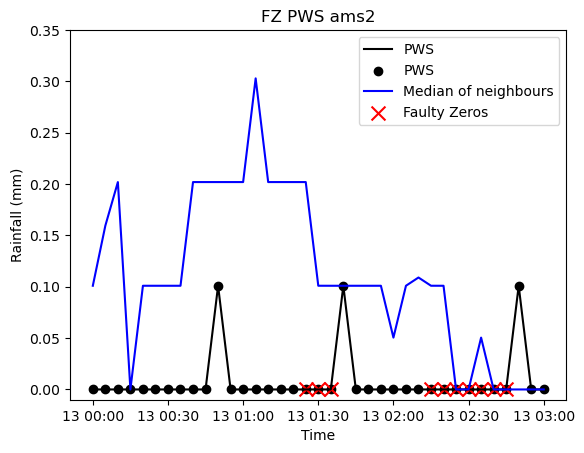

In [12]:
# Print results
Tint_selected = [Tint[i] for i in range(len(FZ_array)) if FZ_array[i] == 1]
Nint_selected = [Nintdf.values[i] for i in range(len(FZ_array)) if FZ_array[i] == 1]
plt.plot(Tint, Nintdf.values, color='k')
plt.scatter(Tint, Nintdf.values, color='k', label='Faulty Zeros')
plt.ylabel("Rainfall (mm)")
plt.xlabel("Time")
plt.title("FZ PWS " + stat_id)
plt.ylim(-0.01, 0.35)
plt.plot(Tint, Med, color="blue")
plt.scatter(Tint_selected, Nint_selected, color="red", marker="x", s=100)
plt.legend(["PWS", "PWS","Median of neighbours", "Faulty Zeros"], loc="upper right")

# 3. Questions

* Describe in your own words what `nint` means.

* The subset starts with 9 zero measurements that are not flagged as FZ. Explain why. Is that also true for other choices of `nint`?

* Try a lower value of `nint` and visualize the results. Explain the implications. 

* Try a higher value of `nint` and visualize the results. Explain the implications. 